In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import skimage.io as io
import os
import math

%matplotlib inline

In [2]:
#Load datasets

#pathPickles = '//home//hristo//swpoolsML//DataSet///Pickles//'
pathPickles = ''

with open(pathPickles + 'X_train.pickle', 'rb') as handle:
  X_train = pickle.load(handle)
with open(pathPickles + 'y_train.pickle', 'rb') as handle:
  y_train = pickle.load(handle)

with open(pathPickles + 'X_test.pickle', 'rb') as handle:
  X_test = pickle.load(handle)
with open(pathPickles + 'y_test.pickle', 'rb') as handle:
  y_test = pickle.load(handle)

with open(pathPickles + 'X_val.pickle', 'rb') as handle:
  X_val = pickle.load(handle)
with open(pathPickles + 'y_val.pickle', 'rb') as handle:
  y_val = pickle.load(handle)


In [3]:
print("X shapes")
print("X train:" + str(X_train.shape))
print("X test:" + str(X_test.shape))
print("X validation:" + str(X_val.shape))

print("y shapes")
print("y train:" + str(y_train.shape))
print("y test:" + str(y_test.shape))
print("y validation:" + str(y_test.shape))

X shapes
X train:(12788, 144, 144, 3)
X test:(4384, 144, 144, 3)
X validation:(1097, 144, 144, 3)
y shapes
y train:(12788, 1)
y test:(4384, 1)
y validation:(4384, 1)


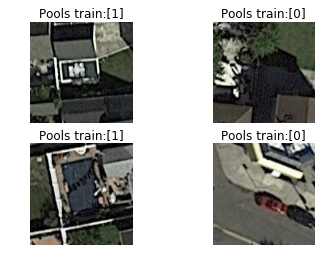

In [4]:
fig=plt.figure()
for i in range(1,5):
    ax=fig.add_subplot(2,2,i)        
    ax.imshow(X_train[i,...])
    ax.set_title('Pools train:' + str(y_train[i]))
    ax.axis('off')

plt.show()

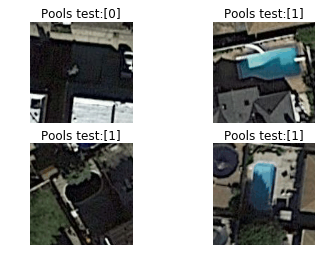

In [5]:
fig=plt.figure()
for i in range(1,5):
    ax=fig.add_subplot(2,2,i)        
    ax.imshow(X_test[i,...])
    ax.set_title('Pools test:' + str(y_test[i]))
    ax.axis('off')

plt.show()

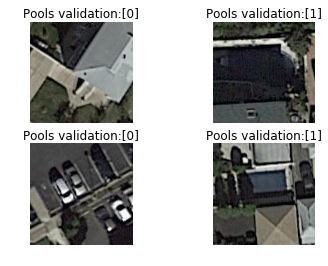

In [6]:
fig=plt.figure()
for i in range(1,5):
    ax=fig.add_subplot(2,2,i)        
    ax.imshow(X_val[i,...])
    ax.set_title('Pools validation:' + str(y_val[i]))
    ax.axis('off')

plt.show()

In [7]:
print("Trim data to use evaluate in batches..")
print("Old shape X Val:", X_val.shape)
print("Old shape y Val:", y_val.shape)
print("Old shape X Test:", X_test.shape)
print("Old shape y Test:", y_test.shape)

eval_batch_size = 50
ds_range_Val = math.floor(X_val.shape[0]/eval_batch_size) * eval_batch_size
X_val = X_val[0:ds_range_Val,...]
y_val = y_val[0:ds_range_Val,...]

ds_range_Test = math.floor(X_test.shape[0]/eval_batch_size) * eval_batch_size
X_test = X_test[0:ds_range_Test,...]
y_test = y_test[0:ds_range_Test,...]

print("New shape X Val:", X_val.shape)
print("New shape y Val:", y_val.shape)
print("New shape X Test:", X_test.shape)
print("New shape y Test:", y_test.shape)


Trim data to use evaluate in batches..
Old shape X Val: (1097, 144, 144, 3)
Old shape y Val: (1097, 1)
Old shape X Test: (4384, 144, 144, 3)
Old shape y Test: (4384, 1)
New shape X Val: (1050, 144, 144, 3)
New shape y Val: (1050, 1)
New shape X Test: (4350, 144, 144, 3)
New shape y Test: (4350, 1)


In [7]:
print(X_train[:,:,:,0].mean())
print(X_train[:,:,:,1].mean())
print(X_train[:,:,:,2].mean())

0.261619
0.268468
0.24064


In [8]:
# Common pitfall. An important point to make about the preprocessing is that any preprocessing statistics (e.g. the data mean) 
# must only be computed on the training data, and then applied to the validation / test data. E.g. 
# computing the mean and subtracting it from every image across the entire dataset and then splitting the data into 
# train/val/test splits would be a mistake. Instead, the mean must be computed only over the training data and then
# subtracted equally from all splits (train/val/test).
dim1 = 0.261619
dim2 = 0.268468
dim3 = 0.240640


X_train[:,:,:,0] -= dim1
X_train[:,:,:,1] -= dim2
X_train[:,:,:,2] -= dim3

print("X_train:")
print(X_train[:,:,:,0].mean())
print(X_train[:,:,:,1].mean())
print(X_train[:,:,:,2].mean())

X_test[:,:,:,0] -= dim1
X_test[:,:,:,1] -= dim2
X_test[:,:,:,2] -= dim3

print("X_test:")
print(X_test[:,:,:,0].mean())
print(X_test[:,:,:,1].mean())
print(X_test[:,:,:,2].mean())


X_val[:,:,:,0] -= dim1
X_val[:,:,:,1] -= dim2
X_val[:,:,:,2] -= dim3

print("X_val:")
print(X_val[:,:,:,0].mean())
print(X_val[:,:,:,1].mean())
print(X_val[:,:,:,2].mean())


X_train:
-7.07169e-07
1.29984e-06
-1.21898e-06
X_test:
-0.000700458
-1.47271e-05
0.000219599
X_val:
0.00217498
0.00197397
0.00240238


In [9]:
print("Reformat labels.")
y_val = y_val.ravel()
y_test = y_test.ravel()
y_train = y_train.ravel()
print("y_val",y_val.shape)
print("y_test",y_test.shape)
print("y_train",y_train.shape)

Reformat labels.
y_val (1050,)
y_test (4350,)
y_train (12788,)


In [10]:
image_size = 144
num_labels = 2
num_channels = 3 

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(X_train, y_train)
del X_train
del y_train

valid_dataset, valid_labels = reformat(X_val, y_val)
del X_val
del y_val

test_dataset, test_labels = reformat(X_test, y_test)
del X_test
del y_test

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (12788, 144, 144, 3) (12788, 2)
Validation set (1050, 144, 144, 3) (1050, 2)
Test set (4350, 144, 144, 3) (4350, 2)


In [11]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [12]:
import operator
from functools import reduce

batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    
    # process on batches beacuse of memory
    tf_valid_dataset = tf.placeholder(
        tf.float32, shape=(eval_batch_size, image_size, image_size, num_channels))
    tf_test_dataset = tf.placeholder(
        tf.float32, shape=(eval_batch_size, image_size, image_size, num_channels))

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    layer3_weights = tf.Variable(tf.truncated_normal(
        [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    # Model.
    def model(data, train=False):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        hidden = tf.nn.max_pool(hidden, [1,2,2,1], [1,2,2,1], padding='SAME')
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        hidden = tf.nn.max_pool(hidden, [1,2,2,1], [1,2,2,1], padding='SAME')
        if train:
            hidden = tf.nn.dropout(hidden, 0.75)
        shape = hidden.get_shape().as_list()
        print(shape, train)
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        if train:
            hidden = tf.nn.dropout(hidden, 0.75)
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, 100, 0.96)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
    
    #initialize variable
    init = tf.global_variables_initializer()
    #use to save variables so we can pick up later
    saver = tf.train.Saver()

[16, 36, 36, 16] False
[50, 36, 36, 16] False
[50, 36, 36, 16] False


In [13]:
## Evaluation/test on batches
def eval_in_batches(session, dataset, placeholder, predictor):
    pred = []
    ds_range = math.ceil(dataset.shape[0]/eval_batch_size)
    for step in range(ds_range):
        offset_start = (step * eval_batch_size)
        if (ds_range-1)!=step:
            offset_end = offset_start + eval_batch_size
        else:
            offset_end = dataset.shape[0]
        batch_data = dataset[offset_start:offset_end, :, :, :]
        feed_dict = {placeholder : batch_data}
        batch = session.run(
          predictor, feed_dict=feed_dict)
        for x in batch:
            pred.append(x.tolist())
    return np.array(pred)

In [14]:
num_steps = 5110

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
    
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 50 == 0):
        
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                eval_in_batches(session, valid_dataset, tf_valid_dataset, valid_prediction), valid_labels))
            
    print('Test accuracy: %.1f%%' % accuracy(
        eval_in_batches(session, test_dataset, tf_test_dataset, test_prediction), test_labels))
    
    saver.save(session, os.path.join(os.getcwd(),'Pools_Model.ckpt'))

Initialized
Minibatch loss at step 0: 6.044853
Minibatch accuracy: 37.5%
Validation accuracy: 48.3%
Minibatch loss at step 50: 0.528298
Minibatch accuracy: 87.5%
Validation accuracy: 51.7%
Minibatch loss at step 100: 0.716892
Minibatch accuracy: 50.0%
Validation accuracy: 54.1%
Minibatch loss at step 150: 0.764536
Minibatch accuracy: 37.5%
Validation accuracy: 57.8%
Minibatch loss at step 200: 0.717473
Minibatch accuracy: 50.0%
Validation accuracy: 61.1%
Minibatch loss at step 250: 0.610174
Minibatch accuracy: 62.5%
Validation accuracy: 66.9%
Minibatch loss at step 300: 0.503735
Minibatch accuracy: 68.8%
Validation accuracy: 68.4%
Minibatch loss at step 350: 0.651924
Minibatch accuracy: 50.0%
Validation accuracy: 70.0%
Minibatch loss at step 400: 0.433383
Minibatch accuracy: 87.5%
Validation accuracy: 67.6%
Minibatch loss at step 450: 0.652921
Minibatch accuracy: 62.5%
Validation accuracy: 74.9%
Minibatch loss at step 500: 0.529321
Minibatch accuracy: 81.2%
Validation accuracy: 76.7%
M